In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-5",
    temperature=0.0
)

sllm = ChatOpenAI(
    model='gpt-5-nano-2025-08-07'
)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_router_llm = sllm.with_structured_output(Route)

def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['income_tax', 'real_estate_tax', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})

    print(f'router route == {route}')
    print(f'route.target == {route.target}')

    return route.target

In [5]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    query = state['query']
    llm_chain = sllm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

In [6]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_agent)
graph_builder.add_node('llm', call_llm)

c:\Users\wjdtp\OneDrive\Desktop\코딩\langgraph_prac\real_estate_tax_graph.py:103: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [7]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)

graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [8]:
graph = graph_builder.compile()

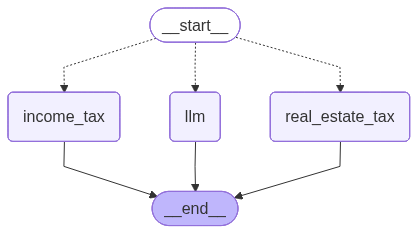

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {'query': '소득세란 무엇인가요?'} # by gpt-4o
graph.invoke(initial_state)

router route == target='income_tax'
route.target == income_tax
context: [Document(id='c4dc4bc0-79f7-4274-b0c5-f743de614138', metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2024. 7. 1.] [법률 제19933호, 2023. 12. 31., 일부개정]\n기획재정부 (세제실세제과) 044-215-4312\n기획재정부 (소득세제과) 044-215-4216\n기획재정부 (음식세원과) 044-215-4233\n기획재정부 (소득세과사원조사팀) 044-215-4217  \n\n제1장 총칙\n제1조(목적)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 조세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[종전 제1조는 제2조로 이동 2009. 12. 31.]\n제2조(정의)\n① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27, 2014. 12. 23, 2018. 12. 31.>\n1. "거주자"란 국내에 주소를 두거나 183일 이상 거소(居所)를 둔 개인을 말한다.\n2. "비거주자"란 거주자가 아닌 개인을 말한다.\n3. "국내법인"이란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n4. "외국법인"이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n5. "사업자"란 사업소득이 있는 거주자를 말한다.\n6. 제1항에 따른 주소·거소와 비거주자의 구분은 대통령령으로 정한다.\n[본조신설 2009. 12. 31.]\n제3조(납세의무)\n다음 각 호의 어느 하나에 해당하는 개인은 이 법에 따라 각자의 소득에 대한 소득세를 납부할 의무를 진다.\n1. 거주자\n2. 비거주자\n3. 법인\n4. 외국법인은 국내사업소(출場所, 그 밖에 이에 

{'query': '소득세란 무엇인가요?',
 'context': [Document(id='c4dc4bc0-79f7-4274-b0c5-f743de614138', metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n[시행 2024. 7. 1.] [법률 제19933호, 2023. 12. 31., 일부개정]\n기획재정부 (세제실세제과) 044-215-4312\n기획재정부 (소득세제과) 044-215-4216\n기획재정부 (음식세원과) 044-215-4233\n기획재정부 (소득세과사원조사팀) 044-215-4217  \n\n제1장 총칙\n제1조(목적)\n이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 조세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[종전 제1조는 제2조로 이동 2009. 12. 31.]\n제2조(정의)\n① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27, 2014. 12. 23, 2018. 12. 31.>\n1. "거주자"란 국내에 주소를 두거나 183일 이상 거소(居所)를 둔 개인을 말한다.\n2. "비거주자"란 거주자가 아닌 개인을 말한다.\n3. "국내법인"이란 법인세법 제2조제1호에 따른 내국법인을 말한다.\n4. "외국법인"이란 법인세법 제2조제3호에 따른 외국법인을 말한다.\n5. "사업자"란 사업소득이 있는 거주자를 말한다.\n6. 제1항에 따른 주소·거소와 비거주자의 구분은 대통령령으로 정한다.\n[본조신설 2009. 12. 31.]\n제3조(납세의무)\n다음 각 호의 어느 하나에 해당하는 개인은 이 법에 따라 각자의 소득에 대한 소득세를 납부할 의무를 진다.\n1. 거주자\n2. 비거주자\n3. 법인\n4. 외국법인은 국내사업소(출場所, 그 밖에 이에 준하는 것을 포함한다. 이하 같다)\n5. 그 밖에 법에 의해 

In [14]:
initial_state = {'query': '집 15억은 세금을 얼마나 내나요?'} #by gpt-5-mini
graph.invoke(initial_state)

router route == target='real_estate_tax'
route.target == real_estate_tax


{'query': '집 15억은 세금을 얼마나 내나요?',
 'answer': '요약(가정)\n- 공시가격 합계 = 15억 원, 공정시장가액비율 r = 60% (질문에 주신 값)\n- 과세표준은 이미 계산하신 값 사용:\n  1) 1세대1주택자: 과세표준 T = 180,000,000원  \n  2) 그 외(개인, 2주택 이하 가정): T = 360,000,000원  \n  3) 법인(기본공제 6억 가정): T = 540,000,000원\n- 추가 가정: 주택분 종합부동산세 산출에는 “납세의무자가 2주택 이하인 개인”용 누진세율표(문서 첫 표)를 적용(법인별도 요율 표가 명시적이지 않아 개인 요율로 계산). 재산세 공제는 미반영(재산세를 알려주시면 공제 반영 가능).\n\n계산(주택분 종합부동산세 산출세액)\n1) 1세대1주택자 (T = 180,000,000원, 과세표준 3억 이하 구간: 0.5%)\n- 세액 = 180,000,000 × 0.005 = 900,000원\n\n2) 그 외 개인 (T = 360,000,000원, 과세표준 3억 초과~6억 이하 구간)\n- 기본액 = 1,500,000원 + (초과액 60,000,000원 × 0.007)\n- 초과분 세액 = 60,000,000 × 0.007 = 420,000원\n- 세액 합계 = 1,500,000 + 420,000 = 1,920,000원\n\n3) 법인 (T = 540,000,000원, 위와 동일 구간(3억~6억) 적용 가정)\n- 초과액 = 540,000,000 − 300,000,000 = 240,000,000원\n- 초과분 세액 = 240,000,000 × 0.007 = 1,680,000원\n- 세액 합계 = 1,500,000 + 1,680,000 = 3,180,000원\n\n주의 및 다음 단계\n- 위 금액들은 주택분 종합부동산세의 “산출세액(계산된 종부세)”입니다. 실제 납부세액 = 산출세액 − (해당 주택에 부과된 주택분 재산세액)입니다. 재산세 공제가 적용되므로 이미 낸 재산세가 있으면 알려주

In [12]:
initial_state = {'query': '강남 텐동은 어디가 맛있나요?'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '강남 텐동은 어디가 맛있나요?',
 'answer': '좋아요! 강남에 텐동 맛집이 많아서 취향에 따라 추천이 달라져요. 몇 가지 정보를 알려주시면 더 정확하게 맞춰드릴 수 있어요.\n\n먼저 간단한 질문\n- 예산대는 어떤가요? (1인당 대략 8,000–12,000원 선 vs 15,000원 이상 등)\n- 분위기? 캐주얼/데이트용/술 안주가 가능해야 하나요?\n- 위치 선호가 있나요? 예: 강남역, 역삼역, 신사동, 청담동 등\n- 포장이나 배달 여부도 중요한가요?\n- 특정 재료(새우 텐동, 카레 텐동 등)나 알레르기/선호가 있나요?\n\n원하시면 지금 바로 최신 정보를 검색해 5~7곳의 후보를 골라\n- 이름, 주소, 대략의 가격대\n- 특징 포인트(바삭함 정도, 소스 맛, 토핑, 공간 분위기)\n- 방문 팁(주차, 대기 시간, 예약 필요 여부)\n까지 정리해 드릴게요. 어떤 취향으로 찾고 계신지 알려주시면 바로 시작하겠습니다.'}